# Анализ связей

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Шаг 1

In [14]:
data = pd.read_csv('hypertension.txt', sep="\t")
data

,psycho,diet,drug,pressure
0,present,absent,1,170
1,present,absent,1,175
2,present,absent,1,165
3,present,absent,1,180
4,present,absent,1,160
...,...,...,...,...
67,absent,present,3,199
68,absent,present,3,170
69,absent,present,3,160
70,absent,present,3,179


### Диаграммы взаимодействия

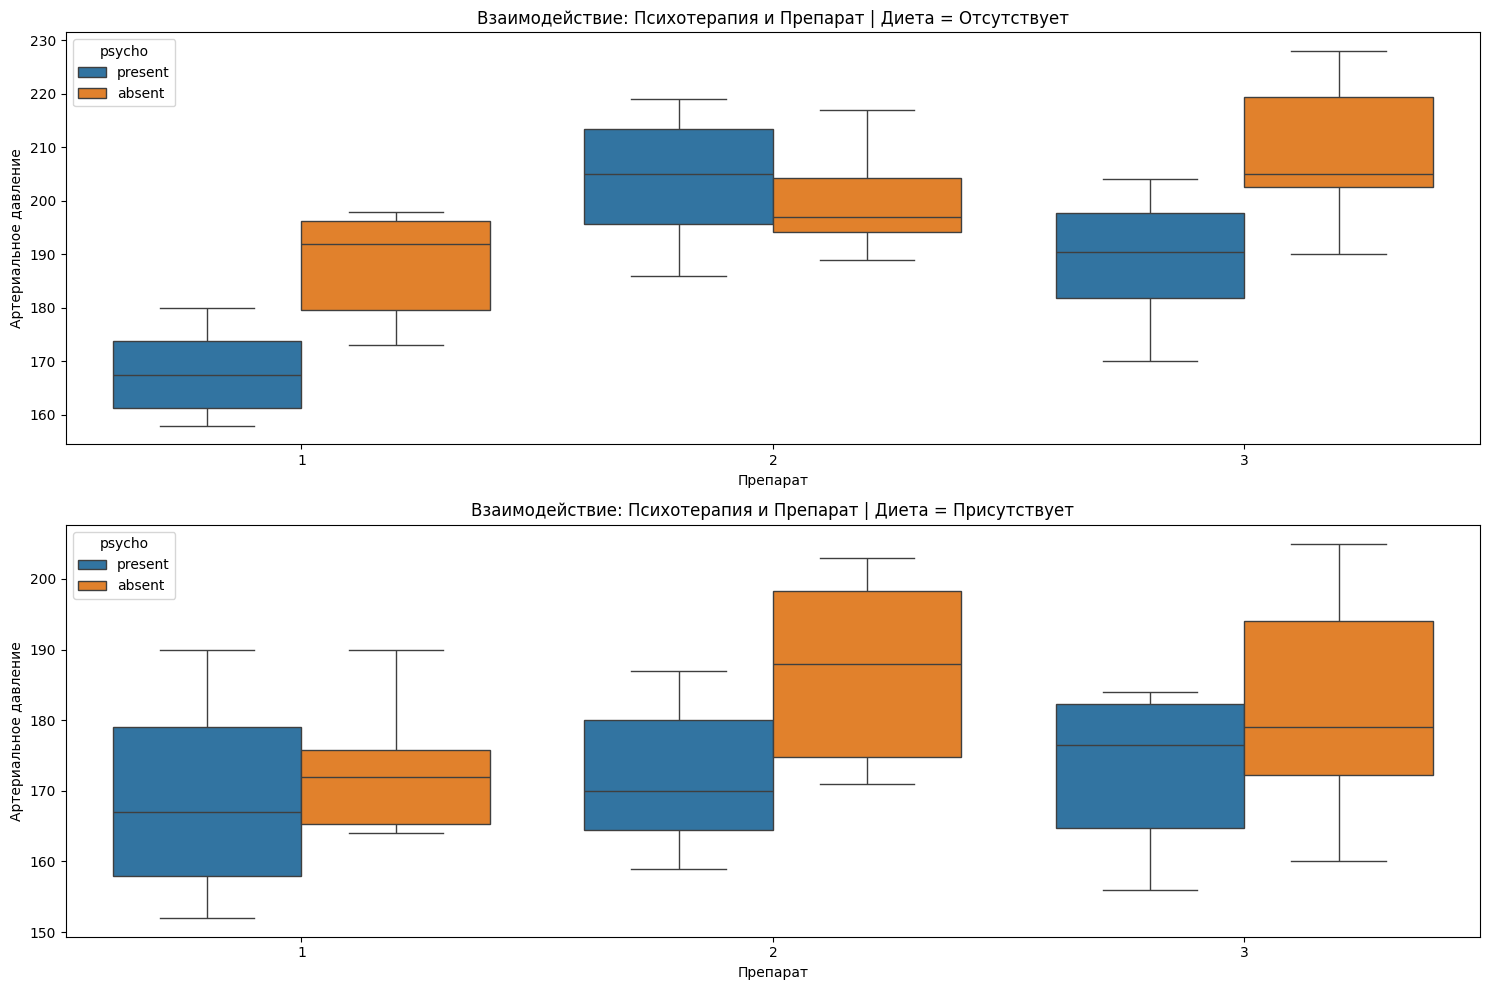

In [15]:
# 1. Взаимодействие между психотерапией и лекарствами при фиксированном значении диеты
plt.figure(figsize=(15, 10))

for i, diet_status in enumerate(['absent', 'present']):
    plt.subplot(2, 1, i + 1)
    sns.boxplot(x='drug', y='pressure', hue='psycho', data=data[data['diet'] == diet_status])
    plt.title(f"Взаимодействие: Психотерапия и Препарат | Диета = {'Отсутствует' if diet_status == 'absent' else 'Присутствует'}")
    plt.xlabel("Препарат")
    plt.ylabel("Артериальное давление")

plt.tight_layout()
plt.show()

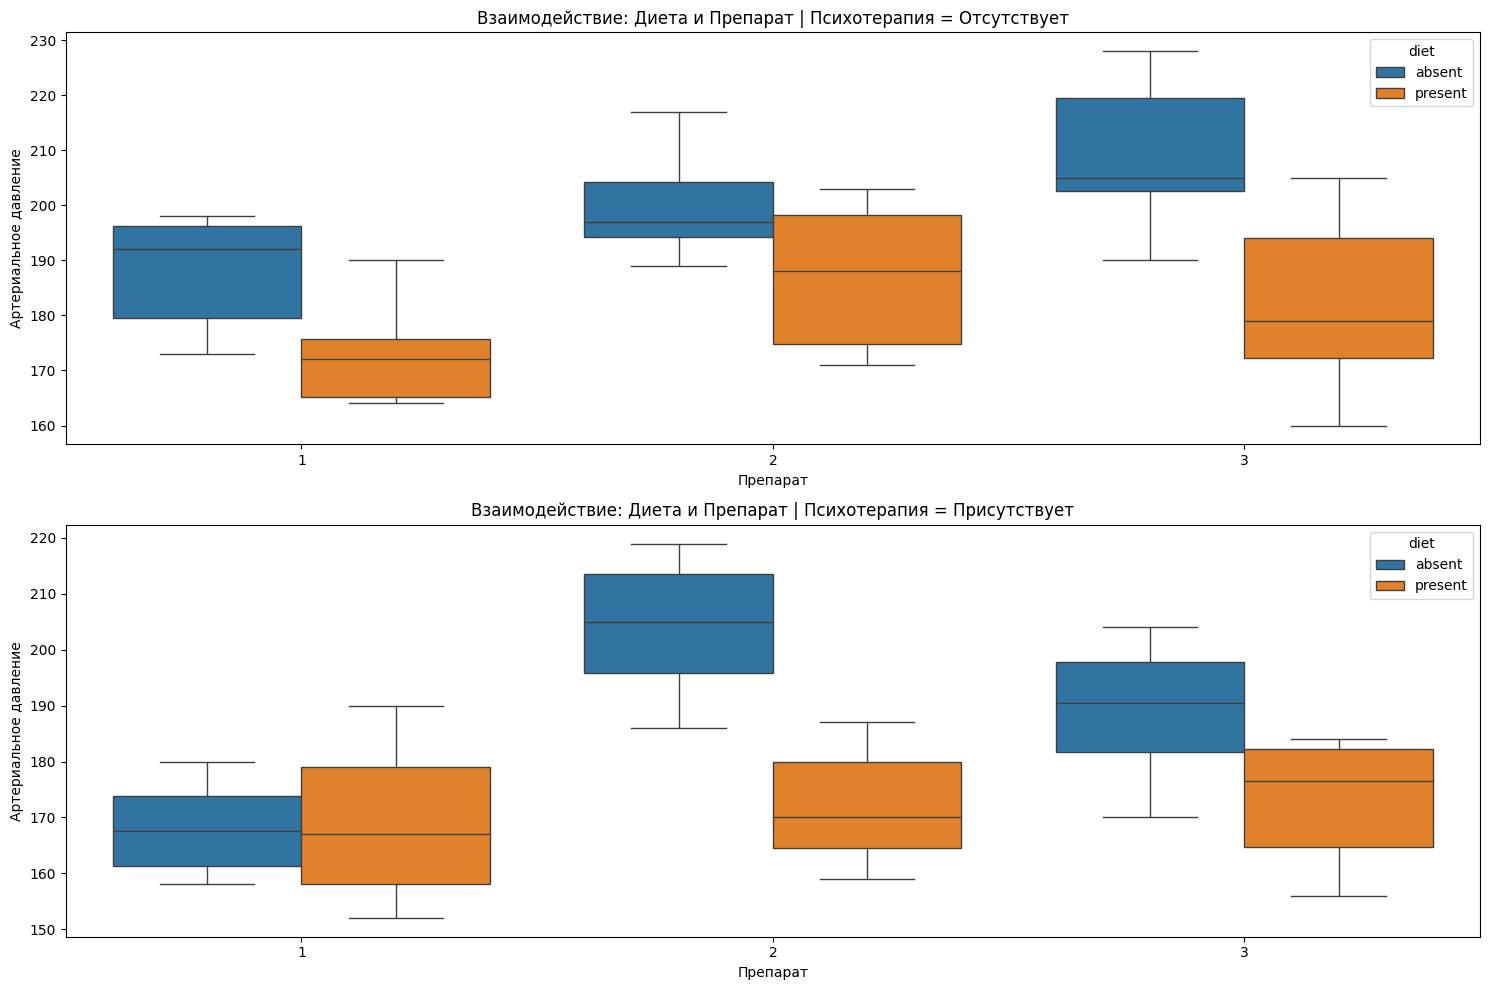

In [16]:
# 2. Взаимодействие между диетой и лекарствами при фиксированном значении психотерапии
plt.figure(figsize=(15, 10))

for i, psycho_status in enumerate(['absent', 'present']):
    plt.subplot(2, 1, i + 1)
    sns.boxplot(x='drug', y='pressure', hue='diet', data=data[data['psycho'] == psycho_status])
    plt.title(f"Взаимодействие: Диета и Препарат | Психотерапия = {'Отсутствует' if psycho_status == 'absent' else 'Присутствует'}")
    plt.xlabel("Препарат")
    plt.ylabel("Артериальное давление")

plt.tight_layout()
plt.show()

## Шаг 2

In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [18]:
# Преобразуем переменные в категориальный формат
data['psycho'] = data['psycho'].astype('category')
data['diet'] = data['diet'].astype('category')
data['drug'] = data['drug'].astype('category')

# Определение модели с учетом всех взаимодействий
model = ols('pressure ~ C(psycho) * C(diet) * C(drug)', data=data).fit()

# Выполнение ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Вывод результатов
print(anova_table)


                           sum_sq    df          F        PR(>F)
C(psycho)                  2048.0   1.0  13.072340  6.150719e-04
C(diet)                    5202.0   1.0  33.204255  3.053308e-07
C(drug)                    3675.0   2.0  11.728723  5.018624e-05
C(psycho):C(diet)            32.0   1.0   0.204255  6.529374e-01
C(psycho):C(drug)           259.0   2.0   0.826596  4.424565e-01
C(diet):C(drug)             903.0   2.0   2.881915  6.381527e-02
C(psycho):C(diet):C(drug)  1075.0   2.0   3.430851  3.883423e-02
Residual                   9400.0  60.0        NaN           NaN


## Шаг 3


In [19]:
# Функция для выполнения анализа
def analyze_subgroup(data_subset, group_description):
    print(f"--- Анализ для группы: {group_description} ---")
    
    # Двусторонний ANOVA
    model = ols('pressure ~ C(diet) * C(drug)', data=data_subset).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\nРезультаты двухстороннего ANOVA:")
    print(anova_table)
    
    # Проверка значимости взаимодействий
    if anova_table['PR(>F)']['C(diet):C(drug)'] < 0.05:
        print("\nЗначимое взаимодействие между диетой и препаратом. Выполняется односторонний ANOVA:")
        for diet_level in data_subset['diet'].unique():
            subset = data_subset[data_subset['diet'] == diet_level]
            print('размер', len(subset))
            model_single = ols('pressure ~ C(drug)', data=subset).fit()
            anova_single = sm.stats.anova_lm(model_single, typ=2)
            print(f"\nОдносторонний ANOVA для диеты {diet_level}:")
            print(anova_single)
    else:
        print("\nВзаимодействие между диетой и препаратом незначимо. Дополнительный анализ не требуется.")
        
    # Определение наилучших условий лечения
    means = data_subset.groupby(['diet', 'drug'])['pressure'].mean()
    print("\nСредние значения давления для каждой комбинации диета-препарат:")
    print(means)
    best_condition = means.idxmin()
    print(f"\nНаилучшие условия для снижения давления: Диета={best_condition[0]}, Препарат={best_condition[1]}")


In [20]:
# Шаг 3: Для пациентов, проходящих психотерапию
psycho_yes = data[data['psycho'] == 'present']
analyze_subgroup(psycho_yes, "Пациенты, проходящие психотерапию")

# Шаг 3': Для пациентов, не проходящих психотерапию
psycho_no = data[data['psycho'] == 'absent']
analyze_subgroup(psycho_no, "Пациенты, не проходящие психотерапию")


--- Анализ для группы: Пациенты, проходящие психотерапию ---

Результаты двухстороннего ANOVA:
                 sum_sq    df          F    PR(>F)
C(diet)          2209.0   1.0  15.248504  0.000496
C(drug)          2342.0   2.0   8.083295  0.001556
C(diet):C(drug)  1634.0   2.0   5.639669  0.008334
Residual         4346.0  30.0        NaN       NaN

Значимое взаимодействие между диетой и препаратом. Выполняется односторонний ANOVA:
размер 18

Односторонний ANOVA для диеты absent:
          sum_sq    df          F    PR(>F)
C(drug)   3924.0   2.0  14.939086  0.000269
Residual  1970.0  15.0        NaN       NaN
размер 18

Односторонний ANOVA для диеты present:
          sum_sq    df         F    PR(>F)
C(drug)     52.0   2.0  0.164141  0.850126
Residual  2376.0  15.0       NaN       NaN

Средние значения давления для каждой комбинации диета-препарат:
diet     drug
absent   1       168.0
         2       204.0
         3       189.0
present  1       169.0
         2       172.0
         3 

C:\Users\Varya02\AppData\Local\Temp\ipykernel_5376\2326297121.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = data_subset.groupby(['diet', 'drug'])['pressure'].mean()
C:\Users\Varya02\AppData\Local\Temp\ipykernel_5376\2326297121.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = data_subset.groupby(['diet', 'drug'])['pressure'].mean()
